# Import Packages

In [72]:
import numpy as np
import tensorflow as tf
import keras
import scipy.misc as sm
import cv2
import matplotlib.pyplot as plt
import time
import keras.backend as K
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import losses
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import image

# Create Memory Map

In [11]:
original_X = np.memmap('./original_X.dat', dtype = np.float32, mode = 'r+', shape = (22424, 224, 224, 3))
original_Y = np.memmap('./original_Y.dat', dtype = np.float32, mode = 'r+', shape = (22424, 1))

<h2> Read CSV File For Image List </h2>

In [6]:
csvList = np.genfromtxt('./imageList.csv', delimiter = ',', dtype = str)

<h2> Read Images Into Memory Map </h2>
<p> (Images Are Normalised And Downsized While Being Read) </p>

In [46]:
def readImages():
    
    for i in range (22424):
        imagePath = "./train/" + csvList[i][0] + "/" + csvList[i][1]
        inputImage = sm.imread(imagePath)
        inputImageResized = sm.imresize(inputImage, (224, 224))
        
        # Normalise values to between 0 ans 1
        original_X[i] = inputImageResized / 255
        original_Y[i] = csvList[i][0][1]
        
        if (i % 50 == 0):
            print ("Images Read : ", i)

In [ ]:
start = time.time()
readImages()
stop = time.time()
print ("22424 Images Read in ", stop - start, " Seconds.")

<h2> Convert Y To One Hot Encoded Form </h2>


In [8]:
def computeOneHot(labels, depth):
    
    c = tf.constant(depth, name = "depth")
    
    # Compute One Hot Encoding
    oneHot = tf.one_hot(labels, c, axis = 0)
    
    # Run Tensor Flow Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        oneHotMatrix = sess.run(oneHot)
        sess.close()
    
    return oneHotMatrix

<h2> Data About Data</h2>

In [140]:
# Compute One Hot Encoding Of Y
oneHot_Y = computeOneHot(original_Y, 10)
oneHot_Y = oneHot_Y.reshape(10, 22424).T

print ("Shape Of X : ", original_X.shape)
print ("Shape Of Y : ", oneHot_Y.shape)
print ("\nNumber Of Images : ", original_X.shape[0])
print ("Size Of Each Image : ", original_X.shape[1], "x", original_X.shape[2], "x", original_X.shape[3])
print ("\nNumber Of Images : ", original_X.shape[0])
print ("Number Of Classes : ", oneHot_Y.shape[1])

print ("\nNumber Of Examples In Each Class : ")

c0 = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
c5 = 0
c6 = 0
c7 = 0
c8 = 0
c9 = 0

for i in range (22424):
    
    if original_Y[i] == 0:
        c0 = c0 + 1
    if original_Y[i] == 1:
        c1 = c1 + 1
    if original_Y[i] == 2:
        c2 = c2 + 1
    if original_Y[i] == 3:
        c3 = c3 + 1
    if original_Y[i] == 4:
        c4 = c4 + 1
    if original_Y[i] == 5:
        c5 = c5 + 1
    if original_Y[i] == 6:
        c6 = c6 + 1
    if original_Y[i] == 7:
        c7 = c7 + 1
    if original_Y[i] == 8:
        c8 = c8 + 1
    if original_Y[i] == 9:
        c9 = c9 + 1
        
print (c0, c1, c2, c3, c4, c5, c6, c7, c8, c9)

Shape Of X :  (22424, 224, 224, 3)
Shape Of Y :  (22424, 10)

Number Of Images :  22424
Size Of Each Image :  224 x 224 x 3

Number Of Images :  22424
Number Of Classes :  10

Number Of Examples In Each Class : 
2489 2267 2317 2346 2326 2312 2325 2002 1911 2129


<h2> Visualise The Data Set </h2>

Category :   7
Image :  img_34020.jpg


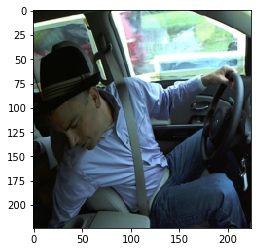

Y Label :  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [144]:
i = 7777
print ("Category :  ", csvList[i][0][1])
print ("Image : ", csvList[i][1])
plt.imshow(original_X[i])
plt.show()
print ("Y Label : ", oneHot_Y[i, :])


<h1> Basic Convolutional Neural Network Using Keras </h1>

In [145]:
def basicCNNModel (inputShape):
    
    # Input 
    X_Input = Input(inputShape)
    
    # Zero Pad
    X = ZeroPadding2D((3, 3))(X_Input)
    
    # Convolution Layer 1
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 1
    X = MaxPooling2D((2, 2))(X)
    
    # Drop Out Layer 1
    X = Dropout(0.3)(X)
    
    # Convolution Layer 2
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 2
    X = MaxPooling2D((2, 2))(X)
    
    # Dropout Layer 2
    X = Dropout(0.3)(X)
    
    # Convolution Layer 3
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = Activation('relu')(X)
    
    # MaxPool Layer 3
    X = MaxPooling2D((2, 2))(X)
    
    # Drop Out Layer 3
    X = Dropout(0.3)(X)
    
    # Flatten X
    X = Flatten()(X)
    
    # Fully Connected Layer 1
    X = Dense(10, activation = 'softmax', name = 'fc0')(X)
    
    # Model
    model = Model(inputs = X_Input, outputs = X, name = 'BasicCNN')
    
    return model

In [146]:
# Get The Model
model = basicCNNModel((original_X.shape[1], original_X.shape[2], original_X.shape[3]))

# Compile The Model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [147]:
# Train The Model
model.fit(x = original_X, y = oneHot_Y, epochs = 2, batch_size = 32)

Epoch 1/2
22424/22424 [==============================] - 2405s 107ms/step - loss: 0.7355 - acc: 0.7621
Epoch 2/2
22424/22424 [==============================] - 2015s 90ms/step - loss: 0.0766 - acc: 0.9771


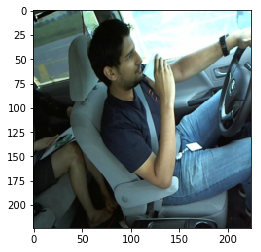

True Label :  6
Predicted :  6


In [166]:
# Predict On Train Set 
i = 2234
imTrainPath = "./train/" + csvList[i][0] + "/" + csvList[i][1]

trainImage = sm.imread(imTrainPath)
trainImage = sm.imresize(trainImage, (224, 224))
trainImage = trainImage / 255
trainImage = trainImage.astype(np.float32)

plt.imshow(trainImage)
plt.show()

trainImage = np.expand_dims(trainImage, axis = 0)

print ("True Label : ", int(original_Y[i]))
print("Predicted : ", np.argmax(model.predict(trainImage)))

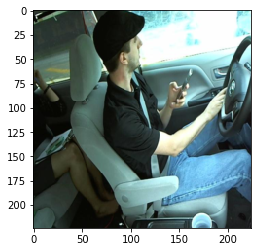

Predicted :  3


In [176]:
# Predict On Test Set 
i = 15648
imTestPath = "./test/img_" + str(i) + ".jpg"
testImage = sm.imread(imTestPath)
testImage = sm.imresize(testImage, (224, 224))
testImage = testImage / 255
testImage = testImage.astype(np.float32)

plt.imshow(testImage)
plt.show()

testImage = np.expand_dims(testImage, axis = 0)

print("Predicted : ", np.argmax(model.predict(testImage)))


In [135]:
pred = model.evaluate (original_X, oneHot_Y)
print ("Loss = " + str(pred[0]))
print ("Train Accuracy = " + str(pred[1]))

5000/5000 [==============================] - 308s 62ms/step
